<a href="https://colab.research.google.com/github/mohsenfayyaz/NLP_Assignments/blob/master/Digikala_Comments_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SENTENCE_MAX_LEN = 300

In [ ]:
import pandas as pd
import numpy as np
import math as math
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/datasets/Digikal_Data.csv')
print(data.shape)
data.head()

(3261, 3)


,Text,Score,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1
1,خرید این محصول رو توصیه میکنم,84,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1


In [ ]:
def filter_digikala_data(df):
    new_df = df.drop(["Score"], axis=1)
    new_df = new_df[(new_df["Suggestion"] == 1) | (new_df["Suggestion"] == 2)]
    return new_df

In [ ]:
def embed_words(df):
    corpus = df.Text.values
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(corpus)

    vocab_size = len(tokenizer.word_index) + 1
    print("Vocab Size:", vocab_size)

    print("Text:", corpus[0])
    encoded_docs = tokenizer.texts_to_sequences(corpus)  # Change words to numbers
    print("embedded:", encoded_docs[0])
    padded_sequence = pad_sequences(encoded_docs, maxlen=SENTENCE_MAX_LEN, padding="post")  # padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.
    print("padded: ", padded_sequence[0])
    print(padded_sequence.shape)
    new_df = df.copy()
    new_df["Text"] = list(padded_sequence)
    return new_df, vocab_size, padded_sequence

In [ ]:
def partition_data(df, test_percent=0.2, validation_percent=0.1, shuffle=True):
    df = df[df["Text"].notna()]
    if shuffle:
        df = df.sample(frac=1)
    test, validate, train = np.split(df, [int(test_percent*len(df)), int((test_percent+validation_percent)*len(df))])
    return train, validate, test

In [ ]:
filtered_data = filter_digikala_data(data)
filtered_data, vocab_size, padded_sequence = embed_words(filtered_data)
filtered_data.head()

Vocab Size: 11218
Text: این اولین تجربه من برای خرید ایفون هست   امروز ب دستم رسیده   به اسم طلایی هست ولی دراصل رزگلده  خیلی هم خوش رنگ هست  
embedded: [4, 415, 434, 10, 12, 50, 3203, 16, 261, 283, 158, 706, 5, 1208, 2120, 16, 15, 11, 9, 328, 124, 16]
padded:  [   4  415  434   10   12   50 3203   16  261  283  158  706    5 1208
 2120   16   15   11    9  328  124   16    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   

,Text,Suggestion
0,"[4, 415, 434, 10, 12, 50, 3203, 16, 261, 283, ...",1
1,"[50, 4, 76, 6, 348, 43, 0, 0, 0, 0, 0, 0, 0, 0...",1
2,"[212, 404, 4, 101, 6, 114, 95, 405, 1262, 67, ...",1
3,"[74, 642, 107, 4, 101, 3, 71, 52, 35, 14, 100,...",1
4,"[74, 439, 2, 808, 3204, 75, 163, 408, 4, 6, 2,...",1


In [ ]:
train_data, validation_data, test_data = partition_data(filtered_data, test_percent=0.2, validation_percent=0.01, shuffle=True)
print("train:     ", train_data.shape)
print("validation:", validation_data.shape)
print("test:      ", test_data.shape)
train_data.head()

train:      (2213, 2)
validation: (28, 2)
test:       (560, 2)


,Text,Suggestion
850,"[74, 10, 4, 46, 6, 3, 540, 24, 90, 55, 5, 30, ...",1
2049,"[55, 5, 279, 54, 2, 19, 753, 263, 108, 47, 726...",1
1584,"[212, 656, 2, 5, 158, 706, 1034, 27, 124, 805,...",1
1200,"[4, 1205, 6, 325, 15, 61, 3, 69, 166, 278, 190...",2
226,"[74, 33, 3388, 702, 402, 358, 22, 345, 226, 11...",1


**Data is Ready**

**Build Model**

In [ ]:
# Build the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding

model = Sequential()

embedding_vector_length = 32
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_vector_length, input_length=SENTENCE_MAX_LEN))

model.add(SpatialDropout1D(0.25))

model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))

model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
# model.add(Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 32)           358976    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 300, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 375,627
Trainable params: 375,627
Non-trainable params: 0
_________________________________________________________________
None


**Train Model**

In [ ]:
tf_train_x = np.asarray(train_data["Text"].to_numpy().tolist())
tf_train_y = train_data["Suggestion"].factorize()[0]
print(tf_train_x.shape)
print(tf_train_x[0])
print(tf_train_y.shape)
print(tf_train_y[0])
history = model.fit(tf_train_x, tf_train_y, validation_split=0.2, epochs=4, batch_size=32)
# np.asarray(train_data["Text"])
# train_data["Text"].values

(2213, 300)
[  74   10    4   46    6    3  540   24   90   55    5   30   37 1611
   26    4   46 4790  227 4791   16    2  294  512  371 2075 4792 1161
   21   14 1384   38 2058  301 4793   41 1517   40 4794    2 4795  204
  140  214  351  143  860   13 4796  586  112  108   60 3511   41    2
   30   37 1410   11 1056    5  709   16 4797   30   37    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0

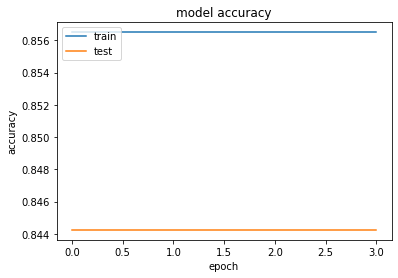

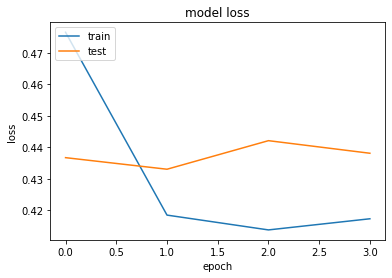

In [ ]:
import matplotlib.pyplot as plt
print(history)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Testing Model**

In [ ]:
tf_test_x = np.asarray(test_data["Text"].to_numpy().tolist())
tf_test_y = test_data["Suggestion"].factorize()[0]
print(tf_test_x.shape)
print(tf_test_y.shape)
print(tf_test_x[5], tf_test_y[5])
np.average(model.predict(tf_test_x[5]))

print("Evaluating...")
model.evaluate(tf_test_x, tf_test_y)

(560, 300)
(560,)
[ 885  343    3   83  420   48  334 2440    3  350 1134    1  652 2076
 2641   37    1  117    3  764 3188 1037    1 1416 1405  973    8   50
 1524  379   83 2932   67  178  791  332  178    1   47  154    8  151
    4   76   48  655   91   23   59  253  267  480    1  261    5  158
  166 1389    7  540  452    8   28  248   26 1340  423    1  392    1
 2255 1178   55    5 3615    2  852   28  457  224  134   16 2002   82
  646   58  231 2113   38 1259 3164    2   23  218   19 3339   40  910
   16  181 2663  839 3451    2   57 1259  919    7  210  495  598 2600
   80 3067  143   13    1  665  297 2473   58  788   17 1439   13    2
   11   22    6 3097  768  407   45    7 1012 2376  321   34   45    1
 2827  444   23 1011    1    8  602   48  117   12  427    2  606   50
    4   76    1    8   70    3 2641   37    6   13 1070   25    6    8
 1371  779  221  261    4   76    5  158  166    1   23   59  253  267
  216  324   25    0    0    0    0    0    0    0    0    

[0.4591434895992279, 0.8339285850524902]